<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr12/Practice12_pu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt




import torchvision
from torchvision.datasets import STL10, CIFAR10
from torchvision import transforms

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu
import numpy as np

In [12]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# utils

In [13]:
train_data = CIFAR10(root='./', train=True, download=True, 
                        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))
test_data = CIFAR10(root='./', train=False, download=True, 
                        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))

Files already downloaded and verified
Files already downloaded and verified


In [14]:
test_data.targets = (np.array(test_data.targets) > 2) * (np.array(test_data.targets) < 8)
test_data.targets = test_data.targets.astype(int)

In [15]:
class PUDataset:
    def __init__(self, data, c=0.5):
        self.data = data
        self.y = (np.array(train_data.targets) > 2) * (np.array(train_data.targets) < 8)
        self.y = self.y.astype(int)

        self.s = (np.random.rand(len(self.y)) < c) * self.y

    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        x, _ = self.data[i]
        return x, self.y[i], self.s[i]

In [16]:
dataset = PUDataset(train_data)

In [17]:
def plot_training(losses, title='Losses'):
    plt.figure()
    x = np.arange(len(losses))

    plt.plot(x, losses, label='loss')

    plt.legend()
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

In [18]:
class Net(nn.Module):
    def __init__(self, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)
        self.last = nn.Linear(out_dim, 1)
        self.sig = nn.Sigmoid()


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return self.sig(self.last(features))

# EN

In [77]:
class EN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = Net()

        self.c = None
        self.alpha = None

    def forward(self, x):
        x = x.to(device)
        return self.net(x)
    
    def batch_loss(self, batch):
        batch_x, _, batch_s = batch

        batch_x = batch_x.to(device).float()
        batch_s = batch_s.to(device)

        y_pred = self(batch_x)
        loss = F.binary_cross_entropy(y_pred.squeeze(), batch_s)

        return loss

    
    def fit(self, traindata, testdata, lr=1e-3, bs=256, num_epochs=20):

        optim = opt.Adam(self.parameters(), lr=lr)
        scheduler = opt.lr_scheduler.ExponentialLR(optim, gamma=0.99)
        train_data, val_data = torch.utils.data.random_split(traindata, (40000, 10000))
        data_loader = torch.utils.data.DataLoader(traindata, bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(testdata, bs, shuffle=True)

        losses = []
        aucs = []
        
        for i in tqdm(range(num_epochs)):
            running_loss = 0
            for (x, _, s) in data_loader:
                p = self(x.to(device)).squeeze()
                loss = F.binary_cross_entropy(p, s.to(device).float())
                optim.zero_grad()
                loss.backward()
                optim.step()

                

                losses.append(loss.item())
            
            preds, true = self.decision_function_loader(test_loader)
            aucs.append(roc_auc_score(true, preds))
            scheduler.step()
        
        self.set_c(val_data)
        return losses, aucs
    
    def decision_function_loader(self, dataloader):
        y_pred = []
        y_true = []

        for (x, y) in dataloader:
            res = self(x.to(device).float())
            y_pred.append(res.squeeze().detach().cpu().numpy())
            y_true.append(y.squeeze().detach().cpu().numpy())

        return np.hstack(y_pred), np.hstack(y_true)


    def set_c(self, val_data):
        self.eval()
        valloader = torch.utils.data.DataLoader(val_data,
                                                batch_size=100,
                                                shuffle=True)

        c = 0
        pos = 0
        unl = 0
        for (x, _, s) in valloader:
            x = x[s==0]

            pos += (s == 1).sum()
            unl += (s == 0).sum()

            out = self(x.to(device))
            out = max(c, out.max().item())
            
        self.c = c
        self.alpha = pos * (1 - c) / c / unl


In [78]:
en = EN().to(device)

In [79]:
res = en.fit(dataset, test_data, num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

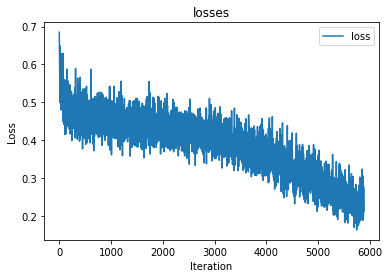

In [80]:
plot_training(res[0], 'losses')

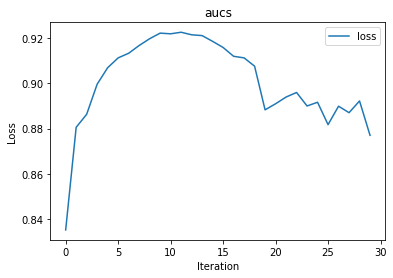

In [81]:
plot_training(res[1], 'aucs')

In [ ]:
en.c, en.pi_est

(0.688219428062439, tensor(0.1480))

# Unbiased/Non-negative risk estimator

In [55]:
class RE(nn.Module):
    def __init__(self, alpha=0.33):
        super().__init__()
        self.net = Net()

        self.alpha = alpha

    def forward(self, x):
        x = x.to(device)
        return self.net(x)
    
    def batch_loss(self, batch):
        raise NotImplementedError()
    
    def _batch_loss(self, batch):
        batch_x, _, batch_s = batch
        batch_x = batch_x.to(device).float()

        batch_p = batch_x[batch_s == 1]
        batch_u = batch_x[batch_s == 0]

        pred_p = self(batch_p)
        pred_u = self(batch_u)

        target_pp = torch.ones_like(pred_p)
        target_pu = torch.zeros_like(pred_p)
        target_uu = torch.zeros_like(pred_u)

        loss_p = self.alpha * F.binary_cross_entropy(pred_p, target_pp)
        loss_n = F.binary_cross_entropy(pred_u, target_uu) - self.alpha * F.binary_cross_entropy(pred_p, target_pu)

        return loss_p, loss_n

    
    def fit(self, traindata, testdata, lr=5e-4, bs=256, num_epochs=20):

        optim = opt.Adam(self.parameters(), lr=lr)
        scheduler = opt.lr_scheduler.ExponentialLR(optim, gamma=0.99)
        data_loader = torch.utils.data.DataLoader(traindata, bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(testdata, bs, shuffle=True)

        losses = []
        aucs = []
        
        for i in tqdm(range(num_epochs)):
            running_loss = 0
            for batch in data_loader:
                loss = self.batch_loss(batch)
                optim.zero_grad()
                loss.backward()
                optim.step()

                running_loss += loss.item()
                losses.append(loss.item())
                
            
            preds, true = self.decision_function_loader(test_loader)
            aucs.append(roc_auc_score(true, preds))
            scheduler.step()
        
        return losses, aucs
    
    def decision_function_loader(self, dataloader):
        y_pred = []
        y_true = []

        for (x, y) in dataloader:
            res = self(x.to(device).float())
            y_pred.append(res.squeeze().detach().cpu().numpy())
            y_true.append(y.squeeze().detach().cpu().numpy())

        return np.hstack(y_pred), np.hstack(y_true)

In [56]:
class nnPU(RE):
    def batch_loss(self, batch):
        loss_p, loss_n = self._batch_loss(batch)
        if loss_n < 0:
            return loss_p
        return loss_p + loss_n


class uPU(RE):
    def batch_loss(self, batch):
        loss_p, loss_n = self._batch_loss(batch)
        return loss_p + loss_n


In [64]:
nnpu = nnPU().to(device)
res = nnpu.fit(dataset, test_data, num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

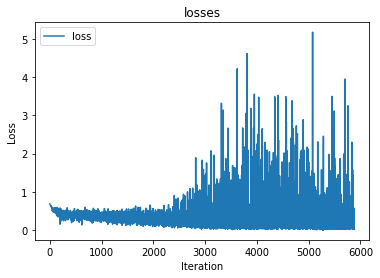

In [65]:
plot_training(res[0], 'losses')

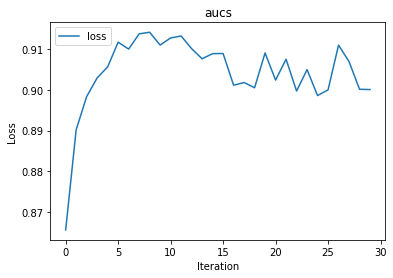

In [66]:
plot_training(res[1], 'aucs')

In [73]:
upu = uPU().to(device)
res2 = upu.fit(dataset, test_data, num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

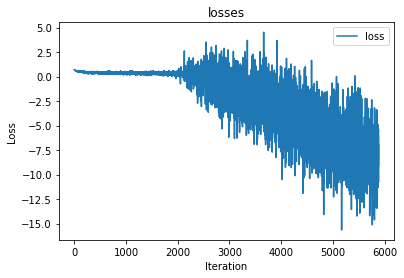

In [74]:
plot_training(res2[0], 'losses')

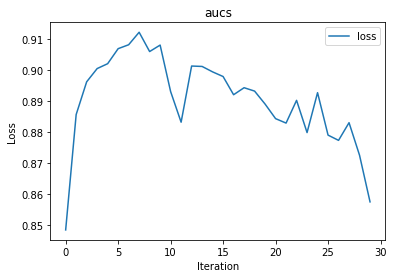

In [75]:
plot_training(res2[1], 'aucs')